# Finding the U_Shape

## 1. Import libraries and data

In [1]:
## Libraries 
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt

In [71]:
## Data
data = pd.read_excel("./BDD_Projet_INSA_V1.xlsx")
### Data cleaning 
data["transfusion CG"][np.where(data["transfusion CG"] > 0)[0]] = 1
data.dropna(inplace=True)
data.set_index(np.arange(len(data)))
data.head()
len(data)

453

## 2. Exploration 

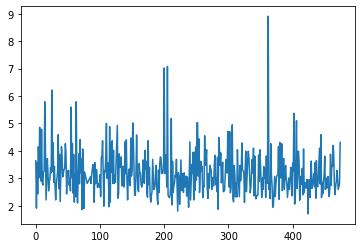

In [3]:
plt.plot(data["fibrinogene"])

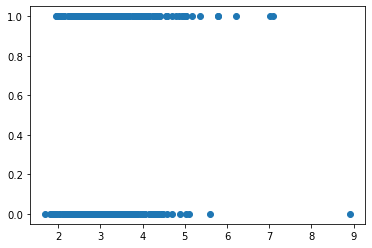

In [6]:
plt.scatter(data["fibrinogene"], data["transfusion CG"])

In [42]:
data.describe()

,transfusion CG,fibrinogene
count,453.000000,453.000000
mean,0.368653,3.197020
std,0.482973,0.823625
min,0.000000,1.700000
25%,0.000000,2.670000
50%,0.000000,3.070000
75%,1.000000,3.620000
max,1.000000,8.910000


In [49]:
data.quantile(0.25)[1]
data.quantile(0.50)[1]
data.quantile(0.75)[1]
data.min()[1]
data.max()[1]

8.91

## 3. Regression logistique sur les données directement

In [7]:
## calcul logit P
import statsmodels.api as sm

x = data["fibrinogene"]
y = data["transfusion CG"]
x_stat = sm.add_constant(x)

model = sm.Logit(y, x_stat)
result = model.fit()

result.summary()

Optimization terminated successfully.
         Current function value: 0.645667
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         transfusion CG   No. Observations:                  453
Model:                          Logit   Df Residuals:                      451
Method:                           MLE   Df Model:                            1
Date:                Tue, 17 Nov 2020   Pseudo R-squ.:                 0.01909
Time:                        08:54:49   Log-Likelihood:                -292.49
converged:                       True   LL-Null:                       -298.18
Covariance Type:            nonrobust   LLR p-value:                 0.0007397
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.8400      0.412     -4.467      0.000      -2.647      -1.033
fibrinogene     0.4042      0.124      3.269      0.001       0.162       0.647
===============================================================================
"""

In [8]:
alpha = -1.8400
beta = 0.4042
logitP = alpha + beta*x

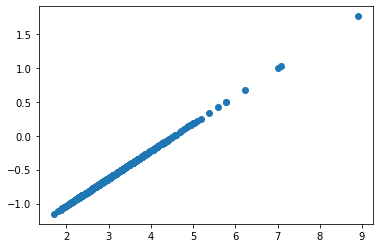

In [9]:
#plt.scatter(data["fibrinogene"], logit(prob(data[np.where(data["transfusion CG"]==1)[0]])))
plt.scatter(data["fibrinogene"], logitP)

On ne retrouve pas la U shape. 

=> Faire une études des résidus

## 4. On interpole nos données par spline et on applique la RL

source : https://www.analyticsvidhya.com/blog/2018/03/introduction-regression-splines-python-codes/?fbclid=IwAR1mhI2HXk-YXLwgvGcRU3-dqFZsz-ENbSgpmAbD6OH3Uiznj8q1PJbu4Zc 

TO DO : 

    1) Ajouter également un test des résidus 
    
    2) Appliquer à tout le dataset entier 
    
    3) Quelles splines sont utilisées? 

In [27]:
# Dividing data into train and validation datasets
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.2, random_state = 1)

In [37]:
from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [55]:
# Divide by quantiles
k2 = data.quantile(0.25)[1]
k3 = data.quantile(0.50)[1]
k4 = data.quantile(0.75)[1]
k5 = data.max()[1]
print(k2)
print(k3)
print(k4)

2.67
3.07
3.62


In [69]:
# Divide by quantiles 2 
k2 = data.quantile(0.05)[1]
k3 = data.quantile(0.50)[1]
k4 = data.quantile(0.95)[1]
k5 = data.max()[1]
print(k2)
print(k3)
print(k4)

2.146
3.07
4.584


In [57]:
# Divide by function
# Dividing the data into 4 bins
df_cut, bins = pd.cut(train_x, 5, retbins=True, right=True)
df_cut.value_counts(sort=False)

(1.695, 2.776]    119
(2.776, 3.852]    188
(3.852, 4.928]     43
(4.928, 6.004]      9
(6.004, 7.08]       3
Name: fibrinogene, dtype: int64

Optimization terminated successfully.
         Current function value: 0.632546
         Iterations 8
         Current function value: 0.636502
         Iterations: 35
0.5009064859663328
0.487400929454399


/Users/sophiayazzourh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


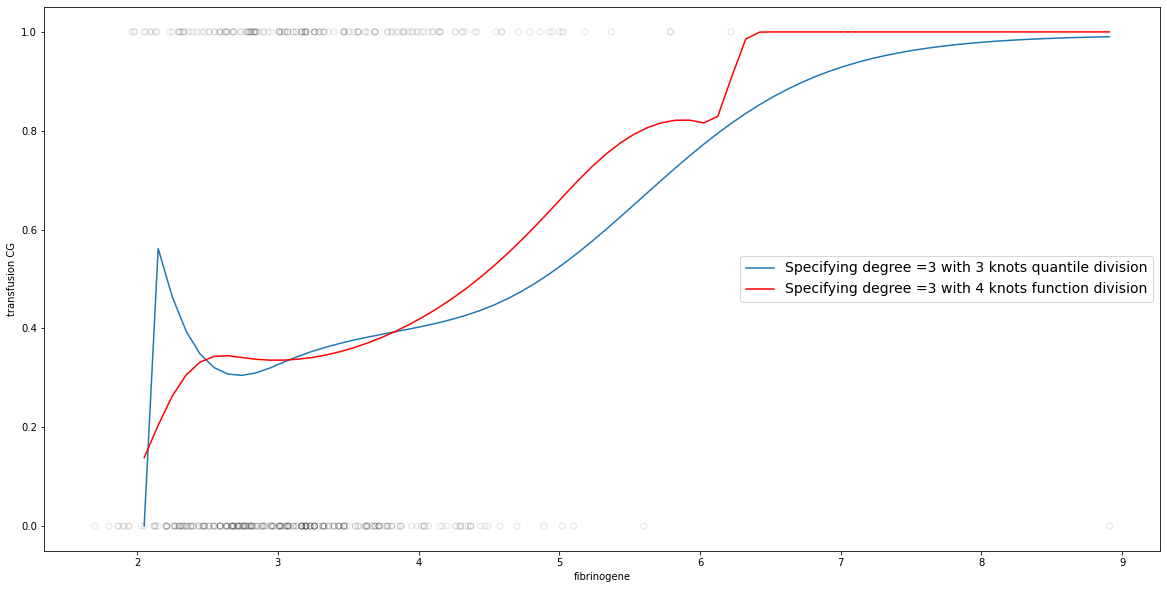

In [70]:
# Generating cubic spline with 3 knots
transformed_x = dmatrix("bs(train, knots=(2.146,3.07,4.584), degree=3, include_intercept=False)", {"train": train_x},return_type='dataframe')

# Fitting Generalised linear model on transformed dataset
fit1 = sm.Logit(train_y, transformed_x).fit()

# Generating cubic spline with 4 knots
transformed_x2 = dmatrix("bs(train, knots=(2.776,3.852,4.928,6.004),degree =3, include_intercept=False)", {"train": train_x}, return_type='dataframe')

# Fitting Generalised linear model on transformed dataset
fit2 = sm.Logit(train_y, transformed_x2).fit()

# Predictions on both splines
pred1 = fit1.predict(dmatrix("bs(valid, knots=(2.146,3.07,4.584), include_intercept=False)", {"valid": valid_x}, return_type='dataframe'))
pred2 = fit2.predict(dmatrix("bs(valid, knots=(2.776,3.852,4.928,6.004),degree =3, include_intercept=False)", {"valid": valid_x}, return_type='dataframe'))

# Calculating RMSE values
rms1 = sqrt(mean_squared_error(valid_y, pred1))
print(rms1)
rms2 = sqrt(mean_squared_error(valid_y, pred2))
print(rms2)

# We will plot the graph for 70 observations only
xp = np.linspace(valid_x.min(),valid_x.max(),70)

# Make some predictions
pred1 = fit1.predict(dmatrix("bs(xp, knots=(2.146,3.07,4.584), include_intercept=False)", {"xp": xp}, return_type='dataframe'))
pred2 = fit2.predict(dmatrix("bs(xp, knots=(2.776,3.852,4.928,6.004),degree =3, include_intercept=False)", {"xp": xp}, return_type='dataframe'))

# Plot the splines and error bands
plt.figure(figsize=(20,10))
plt.scatter(data["fibrinogene"], data["transfusion CG"], facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(xp, pred1, label='Specifying degree =3 with 3 knots quantile division')
plt.plot(xp, pred2, color='r', label='Specifying degree =3 with 4 knots function division')
plt.legend(prop={'size': 14})
plt.xlabel('fibrinogene')
plt.ylabel('transfusion CG')
plt.show()

We know that the behavior of polynomials that are fit to the data tends to be erratic near the boundaries. Such variability can be dangerous. These problems are resembled by splines, too. The polynomials fit beyond the boundary knots behave even more wildly than the corresponding global polynomials in that region. To smooth the polynomial beyond the boundary knots, we will use a special type of spline known as Natural Spline.

A natural cubic spline adds additional constraints, namely that the function is linear beyond the boundary knots. This constrains the cubic and quadratic parts there to 0, each reducing the degrees of freedom by 2. That’s 2 degrees of freedom at each of the two ends of the curve, reducing K+4 to K.


Optimization terminated successfully.
         Current function value: 0.638531
         Iterations 16
0.48347394755322426


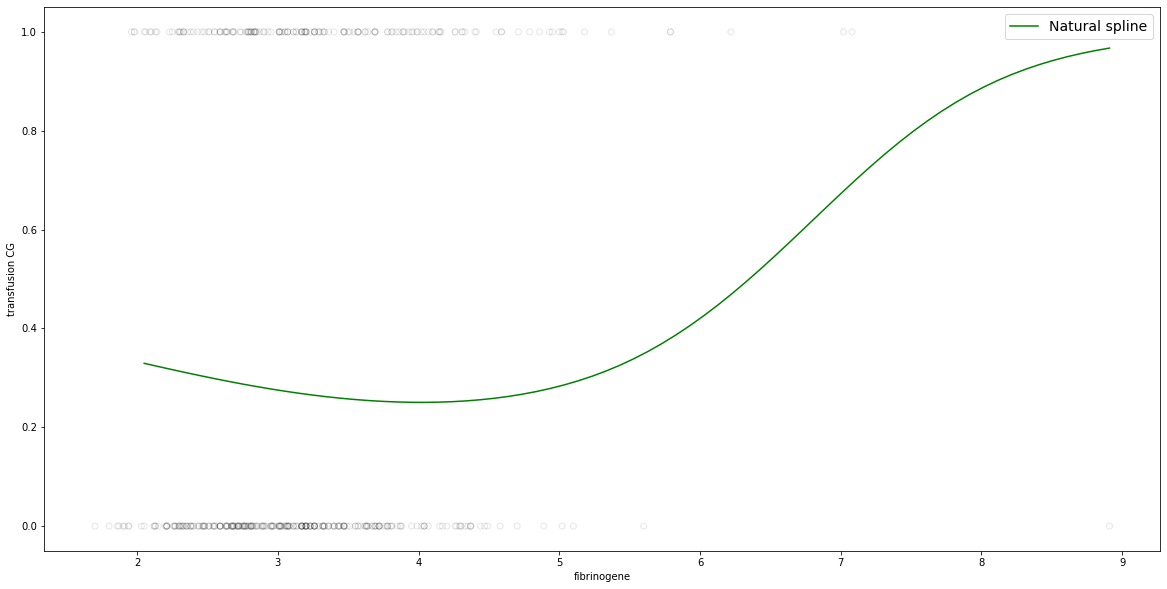

In [68]:
# Generating natural cubic spline
transformed_x3 = dmatrix("cr(train,df = 3)", {"train": train_x}, return_type='dataframe')
fit3 = sm.Logit(train_y, transformed_x3).fit()

# Prediction on validation set
pred3 = fit3.predict(dmatrix("cr(valid, df=3)", {"valid": valid_x}, return_type='dataframe'))
# Calculating RMSE value
rms = sqrt(mean_squared_error(valid_y, pred3))
print(rms)

# We will plot the graph for 70 observations only
xp = np.linspace(valid_x.min(),valid_x.max(),70)
pred3 = fit3.predict(dmatrix("cr(xp, df=3)", {"xp": xp}, return_type='dataframe'))

# Plot the spline
plt.figure(figsize=(20,10))
plt.scatter(data["fibrinogene"], data["transfusion CG"], facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(xp, pred3,color='g', label='Natural spline')
plt.legend(prop={'size': 14})
plt.xlabel('fibrinogene')
plt.ylabel('transfusion CG')
plt.show()

source 2 en R : https://freakonometrics.hypotheses.org/tag/xgboost